In [54]:
import pandas as pd
import networkx as nx
import numpy as np
from scipy.stats import kstest
from scipy.interpolate import interp1d
from typing import Dict, List
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import itertools

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid")

with open('stats.json', 'r') as f:
    stats = json.load(f)


number_nodes: 1882
radius: [15, 2]
diameter: [28, 4]
average_clustering: [0.005066798238955518, 0.001]
average_path_length: [11.748410823170731, 2]
number_cc: [168, 32]


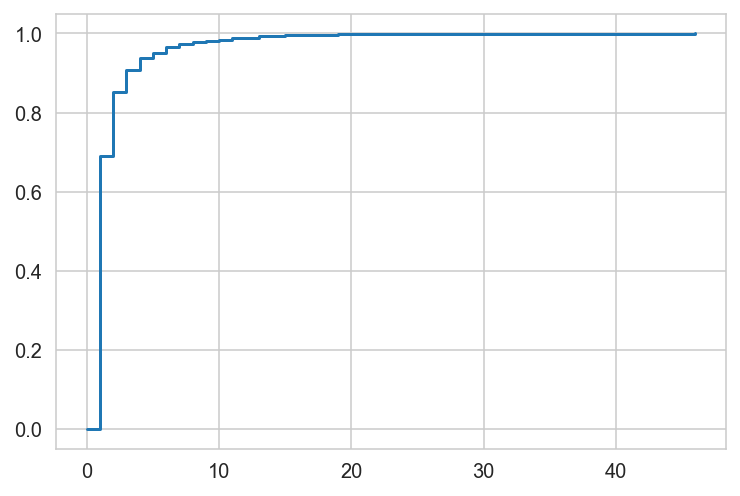

In [55]:
for k, v in stats.items():
    if k != 'degree_cdf':
        print(k, ': ', v, sep='')

q_seq, p_seq = stats['degree_cdf']
plt.plot(
    np.append(np.repeat(q_seq, 2)[1:], q_seq[-1]),
    np.repeat(p_seq, 2)
)
plt.show()


# Auxiliary functions

In [56]:
def GCC(g: nx.Graph) -> nx.Graph:
    return nx.subgraph(g, sorted(list(nx.connected_components(g)), key=len)[-1])


def topN_cc(g: nx.Graph, n: int) -> nx.Graph:
    G_ = g.copy()
    top_cc = sorted(list(nx.connected_components(G_)),
                    key=lambda x: -len(x))[n:]
    nodes_to_remove = list(set.union(*top_cc))
    G_.remove_nodes_from(nodes_to_remove)

    return G_


def CDF(g: nx.Graph) -> List[float]:
    h = nx.degree_histogram(g)

    return np.cumsum(h) / np.sum(h)


def eval_score(G: nx.Graph, stats: dict, silent=False):

    assert len(G.nodes) == stats['number_nodes']

    stats_calculations = {
        'radius': lambda x: nx.radius(GCC(x)),
        'diameter': lambda x: nx.diameter(GCC(x)),
        'average_clustering': lambda x: nx.average_clustering(x),
        'average_path_length': lambda x: nx.average_shortest_path_length(GCC(x)),
        'number_cc': lambda x: len(list(nx.connected_components(x))),
    }

    score_components = []
    stats_graph = []
    score_stats = list(stats_calculations.keys()) + ['degree_cdf']

    for k in score_stats:

        v = stats[k]

        if k in stats_calculations.keys():
            mean = v[0]
            std = v[1]

            G_stat = stats_calculations[k](G)
            score_component = np.exp(-(G_stat-mean)**2/(2*std**2))

        else:
            G_cdf = CDF(G)
            real_cdf = stats['degree_cdf'][1]
            real_cdf = interp1d(stats['degree_cdf'][0], stats['degree_cdf'][1])

            G_stat = kstest(G_cdf, real_cdf)[0]
            score_component = 1 - G_stat

        if not silent:
            print(f"{k} evaluated ✅ | score={np.round(score_component, 2)}")

        score_components.append(score_component)
        stats_graph.append(G_stat)

    assert len(score_components) == 6

    score_dict = dict(zip(score_stats, score_components))
    stats_dict = dict(zip(score_stats, stats_graph))
    mean_score = np.mean(score_components)

    if mean_score < 0.4:
        emoji = '👺'
    elif mean_score < 0.6:
        emoji = '👽'
    else:
        emoji = '🥳'

    if not silent:
        print(f"\nGrade: {np.round(10*mean_score, 1)} {emoji}")

    return score_dict, stats_dict, mean_score


In [4]:
def generate_from_ecdf(n, empirical_cdf, convert_to_int=True):
    PPF = interp1d(empirical_cdf[1], empirical_cdf[0])

    uni_sample = np.random.uniform(0, 0.999, n)
    sample = PPF(uni_sample)

    if convert_to_int:
        sample = sample.astype(int)
    return sample


# Configuration Model (baseline)

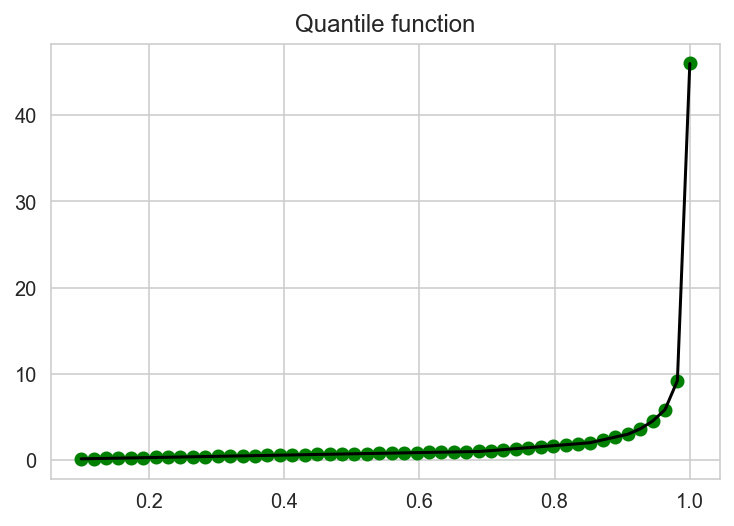

In [5]:
inverted_edf = interp1d(stats['degree_cdf'][1], stats['degree_cdf'][0])

x = np.linspace(0.1, 1)
y = inverted_edf(x)
plt.title("Quantile function")
plt.plot(x, y, 'go', x, y, 'k-')
plt.show()


In [6]:
rs = generate_from_ecdf(stats['number_nodes'], stats['degree_cdf'])

if rs.sum() % 2 != 0:
    rs[0] += 1
G_cm = nx.configuration_model(rs)
G_cm = nx.Graph(G_cm)


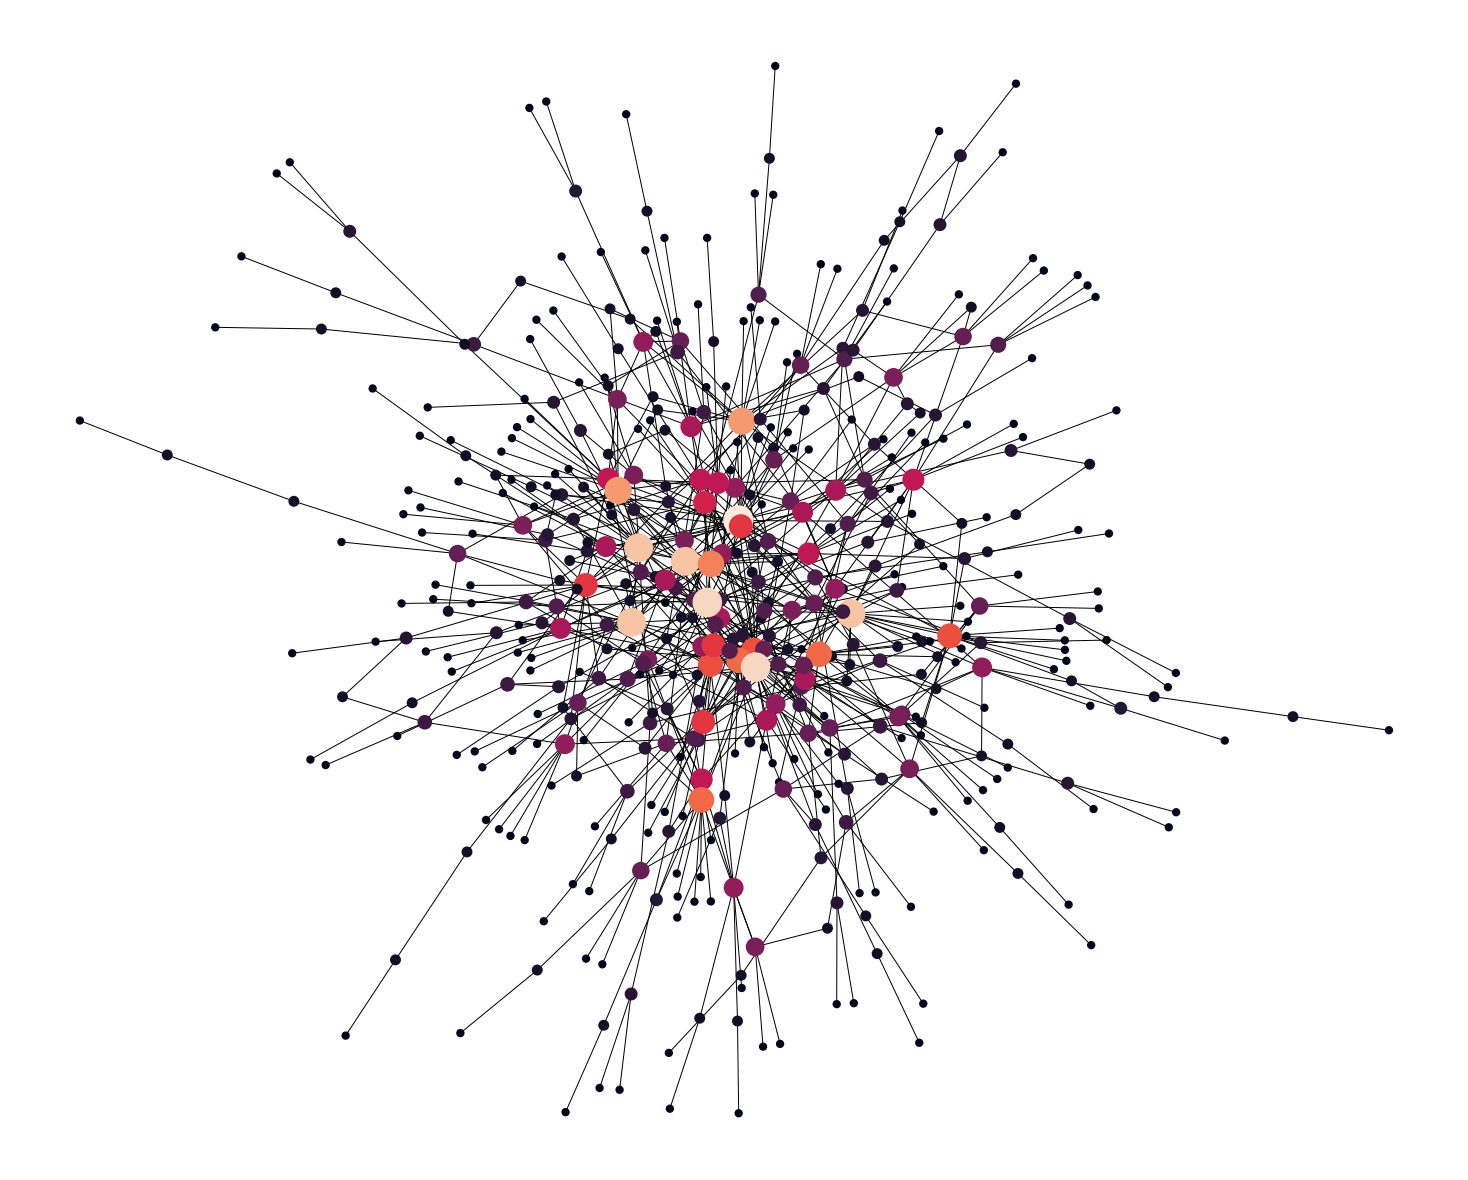

In [7]:
cm_gcc = GCC(G_cm)
degrees = nx.degree(cm_gcc)


plt.figure(figsize=(10, 8))
nx.draw(
    cm_gcc,
    width=0.5,
    node_size=[v*10 for k, v in degrees],
    node_color=[v for k, v in degrees]
)
plt.show()


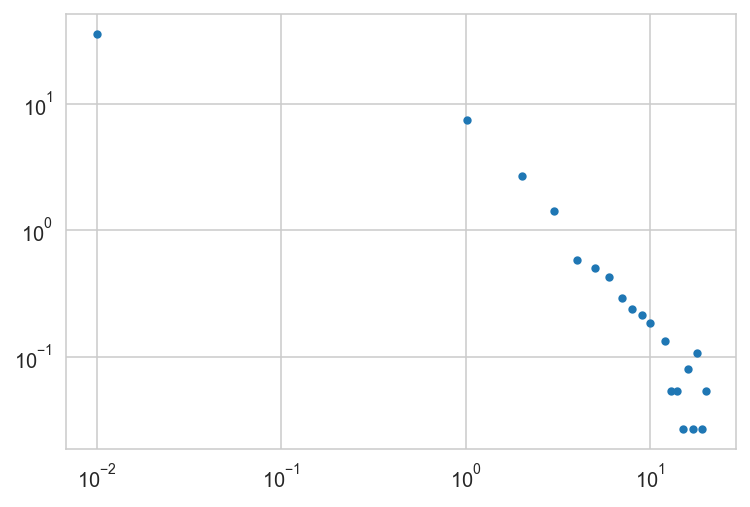

In [8]:
hist, bin_edges = np.histogram(rs, bins=1000, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers, hist, s=10)
plt.xscale('log')
plt.yscale('log')
plt.show()


In [9]:
sd, std, ms = eval_score(G_cm, stats)

radius evaluated ✅ | score=0.0
diameter evaluated ✅ | score=0.0
average_clustering evaluated ✅ | score=0.89
average_path_length evaluated ✅ | score=0.0
number_cc evaluated ✅ | score=0.0
degree_cdf evaluated ✅ | score=0.45

Grade: 2.3 👺


In [ ]:
grades = []
best_score = 0
best_graph = None

for _ in tqdm(range(100)):
    rs = generate_from_ecdf(stats['number_nodes'], stats['degree_cdf'])
    if rs.sum() % 2 != 0:
        rs[0] += 1

    G_cm_iter = nx.configuration_model(rs)
    G_cm_iter = nx.Graph(G_cm_iter)

    sd, std, ms = eval_score(G_cm_iter, stats, silent=True)
    grades.append(ms*10)

    if ms*10 > best_score:
        best_score = ms*10
        best_graph = G_cm_iter

grades = np.array(grades)
nx.write_edgelist(best_graph, data=False, path='gen_graph_1.txt')

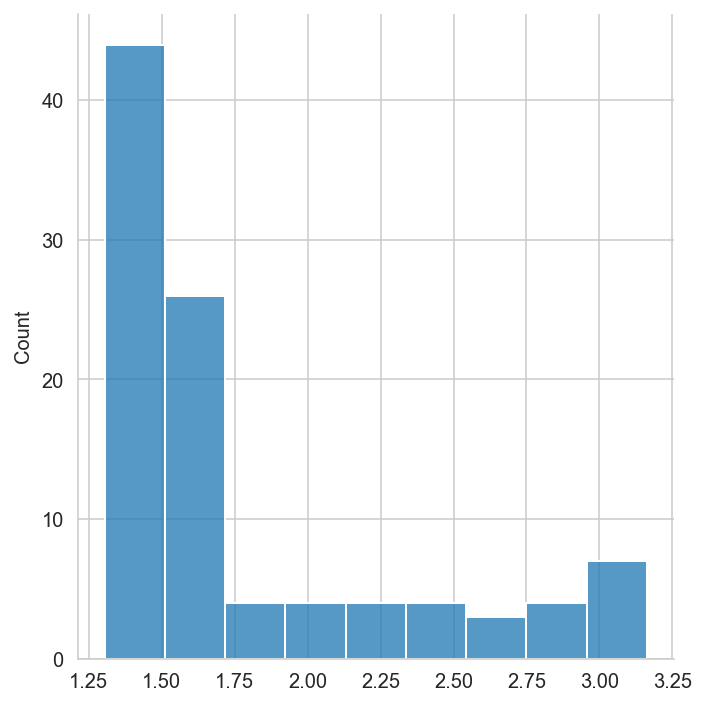

In [302]:
sns.displot(grades)
plt.show()


# Playing with connected components

In [16]:
#best_graph_bcc = best_graph.copy()
#best_graph = best_graph_bcc.copy()
best_graph = nx.read_edgelist('gen_graph_1.txt')

In [18]:
def get_number_cc(g):
    return len(list(nx.connected_components(g)))


best_graph = best_graph_bcc.copy()
ncc = get_number_cc(best_graph)

while ncc > 168:
    smallest_ccs = sorted(list(nx.connected_components(
        best_graph)), key=lambda x: len(x))[:2]
    components_to_connect = [list(i) for i in smallest_ccs]

    assert len(components_to_connect) == 2

    nodes_to_connect = sum(components_to_connect, [])
    edges = itertools.combinations(nodes_to_connect, 2)

    #u = components_to_connect[0][0]
    #v = components_to_connect[1][0]
    #best_graph.add_edge(u, v)

    best_graph.add_edges_from(list(edges)[:1])

    ncc = get_number_cc(best_graph)
    if ncc % 100 == 0:
        # print(ncc)
        pass

    if ncc < 700:
        u = components_to_connect[0][0]
        v = components_to_connect[1][0]
        best_graph.add_edge(u, v)


In [19]:
sd, std, ms = eval_score(best_graph, stats)


radius evaluated ✅ | score=0.0
diameter evaluated ✅ | score=0.0
average_clustering evaluated ✅ | score=0.18
average_path_length evaluated ✅ | score=0.0
number_cc evaluated ✅ | score=1.0
degree_cdf evaluated ✅ | score=0.5

Grade: 2.8 👺


In [440]:
nx.write_edgelist(best_graph, data=False, path='gen_graph_2.txt')